**Probabilistic Gaussian Generative Classifier**

In [2]:
import numpy as np
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
import pandas as pd

np.random.seed(0)

In [3]:
# Load data
digits = load_digits()
X = digits.data  # shape (n_samples, 64)
y = digits.target  # shape (n_samples,)

# Stratified 70/15/15 split
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.15, stratify=y, random_state=0
)
val_ratio_of_temp = 0.15 / (1 - 0.15)  # = 0.1764
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=val_ratio_of_temp, stratify=y_temp, random_state=0
)

# Standardize features using training set stats
scaler = StandardScaler().fit(X_train)
X_train_s = scaler.transform(X_train)
X_val_s = scaler.transform(X_val)
X_test_s = scaler.transform(X_test)

D = X_train_s.shape[1]

output = {
    'split_sizes': {
        'train': X_train_s.shape[0],
        'val': X_val_s.shape[0],
        'test': X_test_s.shape[0]
    },}

print("Data split sizes:", output['split_sizes'])

Data split sizes: {'train': 1257, 'val': 270, 'test': 270}


This function is implementing Gaussian Discriminant Analysis (GDA) with a shared covariance matrix across all classes — also known as Linear Discriminant Analysis (LDA).

It learns the parameters of a multiclass Gaussian classifier:

* Prior probabilities for each class

* Mean vector for each class

* ONE shared covariance matrix for all classes (Σ)

This is used later to build a classifier with linear decision boundaries.

In [4]:
def fit_shared_cov_gaussian(X, y):
    n = X.shape[0] #number of samples
    classes = np.unique(y) #Identify unique class labels
    K = len(classes)
    priors = np.zeros(K) #array to hold prior probabilities for each class
    means = np.zeros((K, X.shape[1])) # array to hold class means for each class

    class_to_idx = {c: i for i, c in enumerate(classes)} #mapping from class label to index

    for c in classes:
        idx = class_to_idx[c]
        Xc = X[y == c]
        priors[idx] = Xc.shape[0] / n # Prior = (# samples in that class) / (total samples)
        means[idx] = Xc.mean(axis=0)  # Mean vector = average of all X values in that class
    S = np.zeros((D, D))
    
    #Because LDA assumes all classes share the same covariance, we compute one matrix:
    for i in range(n):
        c = y[i] 
        #X[i] → the i-th feature vector (the input)
        #y[i] → the i-th label (the class)
        idx = class_to_idx[c]
        diff = (X[i] - means[idx])[:, None] #deviation: (Xi−μk) #Measuring the distance from each point to its class mean
        S += diff @ diff.T   #(Xi−μk) @ (Xi−μk)T
    S /= n  #Shared covariance matrix = 1/n (Xi−μk) @ (Xi−μk)T
    
    return priors, means, S, class_to_idx, classes


**Gaussian generative classifier with shared covariance**

For each class k:
* p(x | y = k) = N(x ; μ_k, Σ)

Prediction uses:
* log p(y = k | x) ∝ log π_k + log N(x ; μ_k, Σ_λ)

N(x ; μ_k, Σ_λ): probability of each feature given class
* log p(x ∣ k) = 1/2 [(x−μ)T Σ^−1 (x−μ) +d log(2π)+ log∣Σ∣ ]

d = number of features = 64

Σ−1 = inverse covariance

∣Σ∣ = determinant of covariance (measure of spread)



In [5]:
class GaussianGenerativeClassifier:
    def __init__(self, reg_lambda=1e-3):
        self.reg_lambda = reg_lambda

    def fit(self, X, y):
        self.priors_, self.means_, S, self.class_to_idx_, self.classes_ = fit_shared_cov_gaussian(X, y)
        self.n_classes_ = len(self.classes_)
        self.cov_ = S + self.reg_lambda * np.eye(S.shape[0]) # Add Regularization : Σλ​=Σ+λI
        #to ensure its invertible

        self.sign_, self.logdet_ = np.linalg.slogdet(self.cov_) #log
        # numeric safety: if sign != 1, add tiny jitter
        #covariance must be positive definite
        if self.sign_ <= 0:
            self.cov_ = self.cov_ + 1e-8 * np.eye(self.cov_.shape[0])
            self.sign_, self.logdet_ = np.linalg.slogdet(self.cov_)
        self.cov_inv_ = np.linalg.inv(self.cov_) # Precompute inverse covariance matrix needed in prediction
        return self

    def predict(self, X): 
        # Compute scores :log p(y=k)+ log p(x∣y=k)
        # then choose the class with max score.
        N = X.shape[0]
        scores = np.zeros((N, self.n_classes_))
        for idx, c in enumerate(self.classes_):
            mean = self.means_[idx]
            diffs = X - mean
            #How far am I from the center of class k
            quad = np.sum(diffs @ self.cov_inv_ * diffs, axis=1) # Quadratic form of Gaussian : (x−μ)T Σ^−1 (x−μ)
            #How likely am I to be generated by class k’s Gaussian cloud?
            logpdf = -0.5 * (quad + X.shape[1] * np.log(2 * np.pi) + self.logdet_) # log p(x∣k) = 1/2 [quad +d log(2π)+ log∣Σ∣ ]
            logprior = np.log(self.priors_[idx] + 1e-16)

            scores[:, idx] = logprior + logpdf # Total log-probability score for class idx
        idxs = np.argmax(scores, axis=1) # Choose class with highest score
        return self.classes_[idxs] 

    def predict_proba(self, X):
        # P(y=k ∣ x) = ?
        N = X.shape[0]
        scores = np.zeros((N, self.n_classes_))
        for idx, c in enumerate(self.classes_):
            mean = self.means_[idx]
            diffs = X - mean
            quad = np.sum(diffs @ self.cov_inv_ * diffs, axis=1)
            logpdf = -0.5 * (quad + X.shape[1] * np.log(2 * np.pi) + self.logdet_)
            logprior = np.log(self.priors_[idx] + 1e-16)
            scores[:, idx] = logprior + logpdf
        maxs = np.max(scores, axis=1, keepdims=True) # For numerical stability
        exps = np.exp(scores - maxs) # Subtract max to prevent overflow
        probs = exps / np.sum(exps, axis=1, keepdims=True) # Normalize to get probabilities by softmax
        return probs #

Hyperparameter tuning for lambda

In [6]:
lambdas = [1e-4, 1e-3, 1e-2, 1e-1]
val_accuracies = []

for lam in lambdas:
    clf = GaussianGenerativeClassifier(reg_lambda=lam)
    clf.fit(X_train_s, y_train)
    y_val_pred = clf.predict(X_val_s)
    acc = accuracy_score(y_val, y_val_pred)
    val_accuracies.append(acc)

results_df = pd.DataFrame({'lambda': lambdas, 'val_accuracy': val_accuracies})

# select best lambda (if tie choose smallest lambda)
best_idx = int(np.argmax(val_accuracies)) #index of best lambda
best_lambda = lambdas[best_idx]

# Retrain on combined train+val with best lambda
X_combined = np.vstack([X_train_s, X_val_s])
y_combined = np.concatenate([y_train, y_val])
final_clf = GaussianGenerativeClassifier(reg_lambda=best_lambda)
final_clf.fit(X_combined, y_combined)
y_test_pred = final_clf.predict(X_test_s)

# Metrics
test_accuracy = accuracy_score(y_test, y_test_pred)
precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_test_pred, average='macro', zero_division=0)
conf_mat = confusion_matrix(y_test, y_test_pred, labels=final_clf.classes_)

In [7]:
# Prepare outputs
output = {
    'validation_table': results_df,
    'best_lambda': best_lambda,
    'test_accuracy': test_accuracy,
    'macro_precision': precision,
    'macro_recall': recall,
    'macro_f1': f1,
    'confusion_matrix': conf_mat,
    'classes': list(final_clf.classes_),
}

# Print summary
print("\nValidation accuracies for lambda values:")
print(output['validation_table'].to_string(index=False))
print(f"\nSelected best lambda: {output['best_lambda']}")
print(f"\nTest accuracy: {output['test_accuracy']:.4f}")
print(f"Macro precision: {output['macro_precision']:.4f}")
print(f"Macro recall: {output['macro_recall']:.4f}")
print(f"Macro F1-score: {output['macro_f1']:.4f}")


Validation accuracies for lambda values:
 lambda  val_accuracy
 0.0001      0.944444
 0.0010      0.944444
 0.0100      0.944444
 0.1000      0.944444

Selected best lambda: 0.0001

Test accuracy: 0.9556
Macro precision: 0.9595
Macro recall: 0.9555
Macro F1-score: 0.9558


**Confusion matrix**

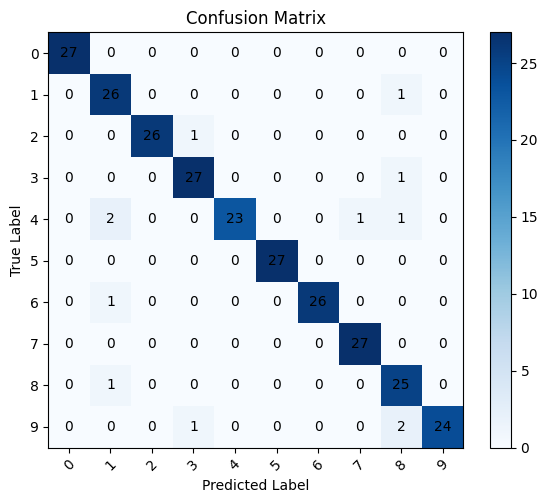

In [8]:
# Confusion matrix (rows=true labels, cols=predicted labels)
cm_df = pd.DataFrame(output['confusion_matrix'], index=output['classes'], columns=output['classes'])

import matplotlib.pyplot as plt
import numpy as np

# Convert to NumPy array
cm = cm_df.values
classes = cm_df.index

plt.figure(figsize=(6, 5))
plt.imshow(cm, cmap='Blues', interpolation='nearest')
plt.title("Confusion Matrix")
plt.colorbar()

# Tick marks
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

# Annotate values
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, str(cm[i, j]),
                 ha='center', va='center')

plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.tight_layout()
plt.show()


**Gaussian Generative Model Report**
------------
1. Explanation of the Generative Model
* We assume p(y) follows a categorical distribution over digit classes (0–9), estimated using class frequencies in the training set.
* For p(x | y), we assume each class generates feature vectors x from a multivariate Gaussian distribution with class‑specific mean μ_k and covariance Σ_k.
------------------


**Parameters π_k, μ_k, and Σ_k are estimated using maximum likelihood:**

**π_k = proportion of samples in class k**

        π_k=  total number of samples/number of training samples in class k

**μ_k = mean of all training samples belonging to class k**

        μ_k = 1/Nk  ∑x_i 
        
**Σ_k = sample covariance of samples in class k :**

This gives you the shape of the cloud for class k

        Σ_k= 1/Nk ∑(x_i-μ_k )(x_i-μ_k )^T

----------------



**Regularization** 

is applied using Σ_λ = Σ + λI to ensure covariance matrices are invertible and to reduce overfitting (for noise). Larger λ increases smoothing.

Overfitting = model memorizes noise

Underfitting = model oversimplifies patterns

Regularization = prevents both by smoothing the covariance and stabilizing the model

---------------


**Discussion**
* The digits most commonly confused are visually similar pairs such as 4/1, 9/8, 3/8.
* Across the tested values of λ (1e−4 to 1e−1), the validation accuracy remained constant at 0.9444. This shows that the model was not very sensitive to the amount of covariance regularisation within this range. The shared covariance matrix was already well-conditioned, so adding more or less regularisation did not significantly affect classification performance. Therefore, the choice of λ had minimal impact on accuracy for this dataset.
A covariance matrix Σ is “well-conditioned” if:
* It can be safely inverted (Σ⁻¹ exists without numerical problems).
* Its eigenvalues are not too small or too large relative to each other.
* The matrix isn’t close to being singular (determinant ≠ 0).
* The Gaussian model performs very well overall.


--------------------------------------------------------------------------------------------------------

**PART B :  Naïve Bayes**
------------

In [9]:

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, f1_score, classification_report
from collections import defaultdict
import seaborn as sns
import matplotlib.pyplot as plt

In [10]:

# Load dataset from UCI repository (or local CSV if available)
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data'
columns = ['age','workclass','fnlwgt','education','education-num','marital-status','occupation',
           'relationship','race','sex','capital-gain','capital-loss','hours-per-week','native-country','income']

df = pd.read_csv(url, names=columns, sep=',\s*', engine='python')
df.head()


,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


## Exploratory Data Analysis

--- B1. Class Distribution & Feature Analysis ---


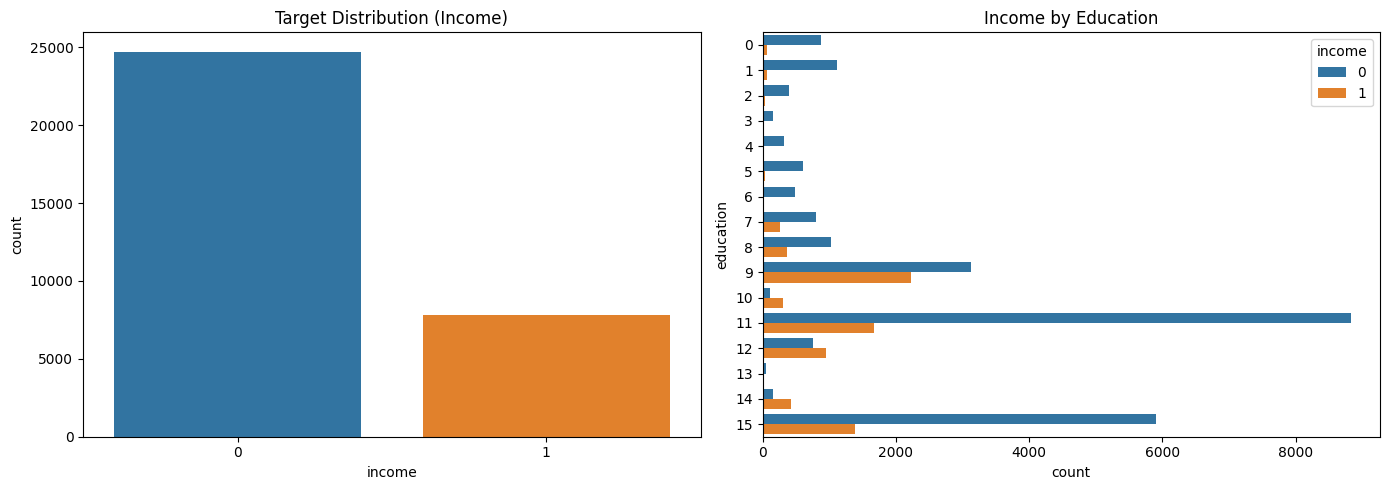

In [41]:
print("--- B1. Class Distribution & Feature Analysis ---")
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot Class Balance
sns.countplot(x='income', data=df, ax=axes[0])
axes[0].set_title("Target Distribution (Income)")

# Plot Feature Relationship (Education vs Income)
sns.countplot(y='education', hue='income', data=df, ax=axes[1])
axes[1].set_title("Income by Education")
plt.tight_layout()
plt.show()

Data Preprocessing

In [42]:

# Select categorical features
categorical_features = ['workclass','education','education-num','marital-status','occupation','relationship','sex','race','native-country']
target = 'income'

# Handle missing values: replace '?' with 'Unknown'
df[categorical_features] = df[categorical_features].replace('?', 'Unknown')

# Encode categorical features as integers
label_encoders = {}
for col in categorical_features + [target]:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

# Split into features and target
X = df[categorical_features].values
y = df[target].values

# Train/validation/test split: 70/15/15 (stratified)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

print("Train size:", X_train.shape[0])
print("Validation size:", X_val.shape[0])
print("Test size:", X_test.shape[0])


Train size: 22792
Validation size: 4884
Test size: 4885


Naive Bayes Class Implementation:

In [43]:

class NaiveBayesClassifier:
    def __init__(self, alpha=1.0):
        self.alpha = alpha # Laplace smoothing parameter  
        self.class_priors = {} # P(class=k)
        self.feature_likelihoods = {} # P(feature value ∣ class)

    def fit(self, X, y):
        self.classes = np.unique(y) # Identify unique class labels
        n_classes = len(self.classes) 
        n_features = X.shape[1] # number of columns in X

        # Compute class priors

        # P(class=k) = (N_k + α) / (N + α*K)
        # N_k = number of samples in class k
        # N = total number of samples
        # K = number of classes

        self.class_priors = {c: (np.sum(y==c) + self.alpha)/(len(y) + self.alpha*n_classes) for c in self.classes} 

        # Compute feature likelihoods

        self.feature_likelihoods = {c: [defaultdict(lambda: self.alpha) for _ in range(n_features)] for c in self.classes} # P(feature value ∣ class)
        
        for c in self.classes:
            X_c = X[y==c] # Samples in unique class c
            for f in range(n_features): # For each feature
                values, counts = np.unique(X_c[:, f], return_counts=True) 
                for val, count in zip(values, counts):
                    # P(feature value = v ∣ class = c) = ( count(value v in class c) + α) / (N_c + α * k)
                    # N_c = number of samples in class c
                    # k = number of unique values for feature f in class c 
                    self.feature_likelihoods[c][f][val] = (count + self.alpha) / (len(X_c) + self.alpha*len(values))

    def predict_proba(self, X): # P(y=c ∣ x) = ?
        probs = []
        for x in X:
            class_probs = {}
            for c in self.classes:
                prob = np.log(self.class_priors[c]) # log P(class=c)
                for f, val in enumerate(x):
                    prob += np.log(self.feature_likelihoods[c][f].get(val, self.alpha)) # sum of all logs of P(feature values ∣ class = c)
                class_probs[c] = prob
            # Normalize
            max_prob = max(class_probs.values()) # normalize negative probabilities to prevent overflow
            exp_probs = {c: np.exp(class_probs[c]-max_prob) for c in self.classes} 
            total = sum(exp_probs.values()) 
            probs.append({c: p/total for c, p in exp_probs.items()})
        return probs

    def predict(self, X):
        return [max(p, key=p.get) for p in self.predict_proba(X)] # Choose class with highest probability


Train and Evaluate Naive Bayes with Different Alpha Values:

   Alpha  Validation Accuracy  F1-Score
0    0.1             0.807125  0.639080
1    0.5             0.806511  0.638623
2    1.0             0.806716  0.639419
3    2.0             0.806716  0.639695
4    5.0             0.805897  0.638995


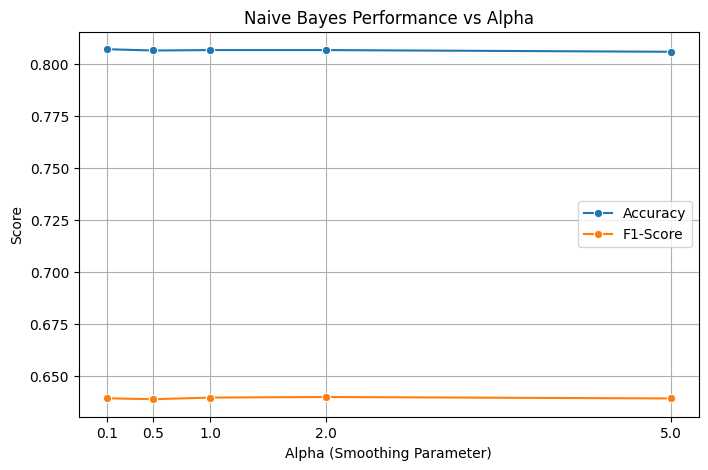

Selected Best Alpha: 2.0


In [44]:

alphas = [0.1, 0.5, 1.0, 2.0, 5.0]
results = []
best_alpha = 1.0
best_f1 = 0

for alpha in alphas:
    nb = NaiveBayesClassifier(alpha=alpha)
    nb.fit(X_train, y_train)
    y_pred = nb.predict(X_val)
    acc = accuracy_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred)
    results.append({'Alpha': alpha, 'Validation Accuracy': acc, 'F1-Score': f1})
    if f1 > best_f1:
        best_f1 = f1
        best_alpha = alpha

# Convert results to DataFrame
df_alpha = pd.DataFrame(results)
print(df_alpha)

# Plot Accuracy and F1-Score vs Alpha
plt.figure(figsize=(8,5))
sns.lineplot(data=df_alpha, x='Alpha', y='Validation Accuracy', marker='o', label='Accuracy')
sns.lineplot(data=df_alpha, x='Alpha', y='F1-Score', marker='o', label='F1-Score')
plt.title("Naive Bayes Performance vs Alpha")
plt.xlabel("Alpha (Smoothing Parameter)")
plt.ylabel("Score")
plt.xticks(alphas)
plt.grid(True)
plt.legend()
plt.show()
print(f"Selected Best Alpha: {best_alpha}")


Feature Subset Analysis:

                                            Features  Validation Accuracy  \
0                       marital-status, relationship             0.715192   
1                           education, education-num             0.744881   
2                              occupation, workclass             0.756552   
3                       native-country, relationship             0.755733   
4                                          sex, race             0.759214   
5  workclass, education, education-num, marital-s...             0.806716   

   F1-Score  
0  0.590762  
1  0.486397  
2  0.279830  
3  0.068696  
4  0.000000  
5  0.639419  


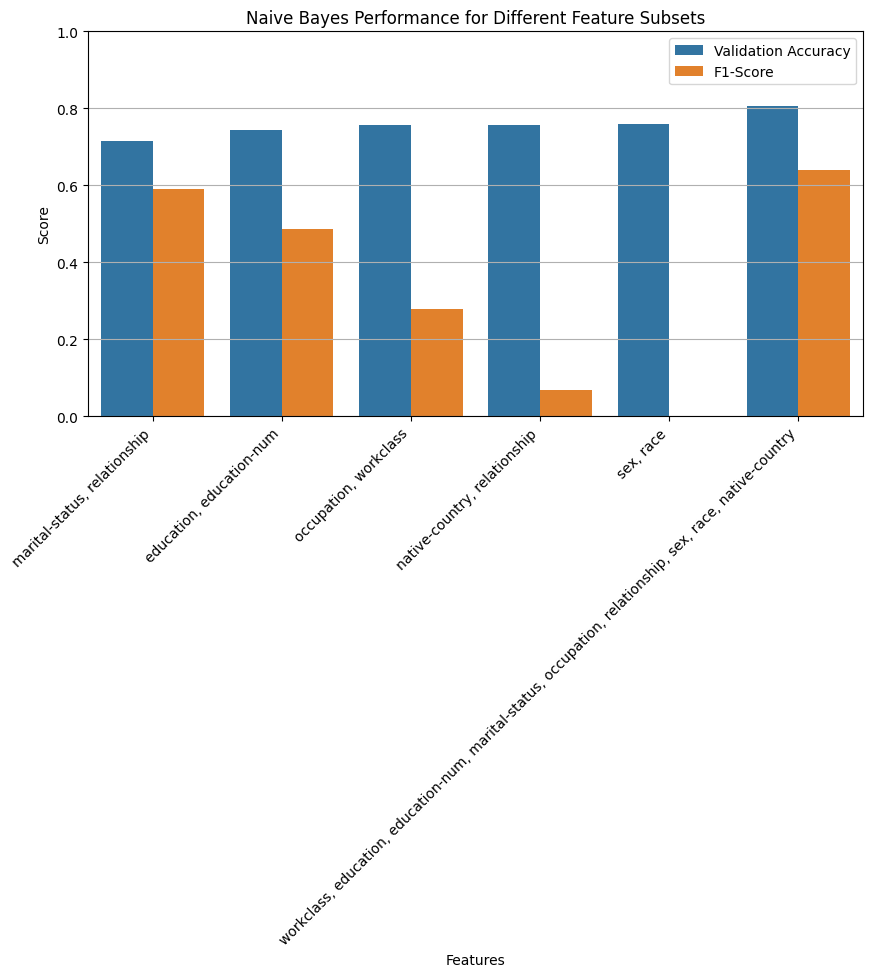

In [45]:


feature_subsets = [
    ['marital-status', 'relationship'],              # Strong dependency (BAD)
    ['education', 'education-num'],                  # Strong dependency (BAD)
    ['occupation', 'workclass'],                     # Strong dependency (BAD)
    ['native-country','relationship'],               # Weak dependency (GOOD)
    ['sex', 'race'],                                 # Weak dependency (GOOD)
    categorical_features                              # All categorical features
]

subset_results = []

for subset in feature_subsets:
    indices = [categorical_features.index(f) for f in subset]
    X_train_subset = X_train[:, indices]
    X_val_subset = X_val[:, indices]

    nb = NaiveBayesClassifier(alpha=1.0)
    nb.fit(X_train_subset, y_train)
    y_pred = nb.predict(X_val_subset)
    acc = accuracy_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred)
    subset_results.append({'Features': ', '.join(subset), 'Validation Accuracy': acc, 'F1-Score': f1})

# Convert results to DataFrame
df_features = pd.DataFrame(subset_results)
print(df_features)

# Plot Accuracy and F1-Score for feature subsets
plt.figure(figsize=(10,5))
sns.barplot(data=df_features.melt(id_vars='Features', value_vars=['Validation Accuracy','F1-Score']),
            x='Features', y='value', hue='variable')
plt.title("Naive Bayes Performance for Different Feature Subsets")
plt.ylabel("Score")
plt.xticks(rotation=45, ha='right')
plt.ylim(0,1)
plt.grid(axis='y')
plt.legend(title='')
plt.show()


Probability Distribution Plot:

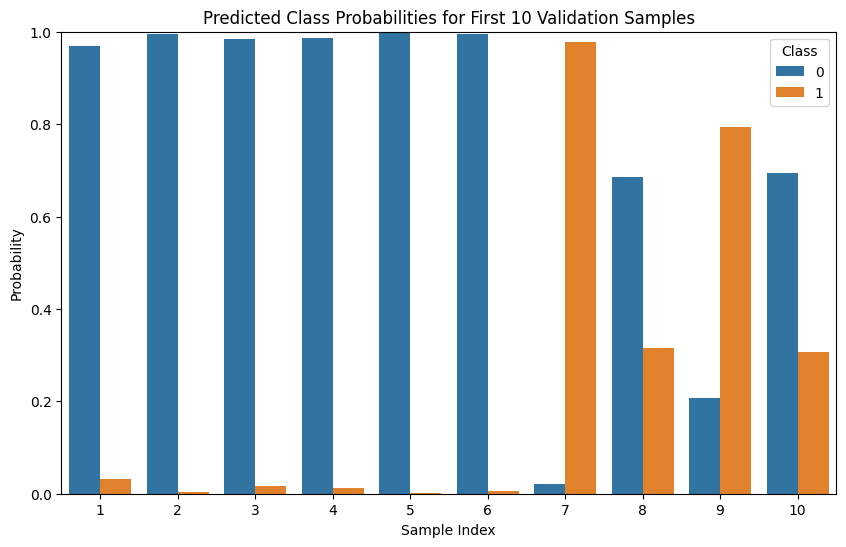

In [46]:

nb = NaiveBayesClassifier(alpha=best_alpha)
nb.fit(X_train, y_train)
probs = nb.predict_proba(X_val)

# Convert to DataFrame for plotting (first 10 samples for clarity)
plot_df = pd.DataFrame(probs[:10])
plot_df['Sample'] = range(1, len(plot_df)+1)
plot_df = plot_df.melt(id_vars='Sample', var_name='Class', value_name='Predicted Probability')

# Map class integers to readable labels if needed
class_mapping = {i: label_encoders[target].inverse_transform([i])[0] for i in range(len(label_encoders[target].classes_))}
plot_df['Class'] = plot_df['Class'].map(class_mapping)

# Plot
plt.figure(figsize=(10,6))
sns.barplot(data=plot_df, x='Sample', y='Predicted Probability', hue='Class')
plt.title("Predicted Class Probabilities for First 10 Validation Samples")
plt.ylabel("Probability")
plt.xlabel("Sample Index")
plt.ylim(0, 1)
plt.legend(title='Class')
plt.show()


Independence Assumption Discussion

In [47]:

print("\n--- Independence Assumption Discussion ---")
discussion = """
Violation Analysis:
The Naive Bayes assumption states that features are independent given the class. 
In the Adult dataset, this is clearly violated. 
1. 'marital-status' and 'relationship' are highly correlated (e.g., 'Husband' implies 'Married').
2. 'education' (categorical) implies exact correlation with 'education-num' (though we only used categorical here).
Impact:
Violating this assumption leads to 'double counting' evidence. This makes the model 
overconfident, pushing probabilities towards 0 or 1 (making the histogram U-shaped), 
though it often maintains good ranking/classification accuracy.
"""
print(discussion)


--- Independence Assumption Discussion ---

Violation Analysis:
The Naive Bayes assumption states that features are independent given the class. 
In the Adult dataset, this is clearly violated. 
1. 'marital-status' and 'relationship' are highly correlated (e.g., 'Husband' implies 'Married').
2. 'education' (categorical) implies exact correlation with 'education-num' (though we only used categorical here).
Impact:
Violating this assumption leads to 'double counting' evidence. This makes the model 
overconfident, pushing probabilities towards 0 or 1 (making the histogram U-shaped), 
though it often maintains good ranking/classification accuracy.



Compare with sklearn's MultinomialNB:

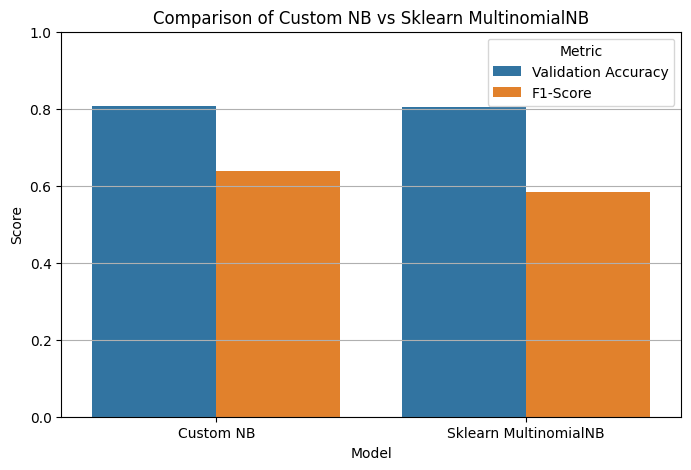

Custom Naive Bayes:
  Accuracy: 0.8067158067158067
  F1-Score: 0.6394194041252864

Sklearn MultinomialNB:
  Accuracy: 0.8032350532350533
  F1-Score: 0.5838025119099177


In [48]:
from sklearn.naive_bayes import MultinomialNB

# Train sklearn MultinomialNB
mnb = MultinomialNB(alpha=1.0)
mnb.fit(X_train, y_train)
y_pred_sklearn = mnb.predict(X_val)
acc_sklearn = accuracy_score(y_val, y_pred_sklearn)
f1_sklearn = f1_score(y_val, y_pred_sklearn)

# Custom Naive Bayes (for comparison)
nb = NaiveBayesClassifier(alpha=1.0)
nb.fit(X_train, y_train)
y_pred_custom = nb.predict(X_val)
acc_custom = accuracy_score(y_val, y_pred_custom)
f1_custom = f1_score(y_val, y_pred_custom)

# Create DataFrame for plotting
df_compare = pd.DataFrame({
    'Model': ['Custom NB', 'Sklearn MultinomialNB'],
    'Validation Accuracy': [acc_custom, acc_sklearn],
    'F1-Score': [f1_custom, f1_sklearn]
})

# Melt for seaborn
df_plot = df_compare.melt(id_vars='Model', var_name='Metric', value_name='Score')

# Plot
plt.figure(figsize=(8,5))
sns.barplot(data=df_plot, x='Model', y='Score', hue='Metric')
plt.ylim(0,1)
plt.title("Comparison of Custom NB vs Sklearn MultinomialNB")
plt.ylabel("Score")
plt.xlabel("Model")
plt.grid(axis='y')
plt.show()
print("Custom Naive Bayes:")
print("  Accuracy:", acc_custom)
print("  F1-Score:", f1_custom)

print("\nSklearn MultinomialNB:")
print("  Accuracy:", acc_sklearn)
print("  F1-Score:", f1_sklearn)




--- Final Evaluation on Test Set ---
Final Test Accuracy: 0.8031
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.84      0.87      3709
           1       0.57      0.70      0.63      1176

    accuracy                           0.80      4885
   macro avg       0.74      0.77      0.75      4885
weighted avg       0.82      0.80      0.81      4885



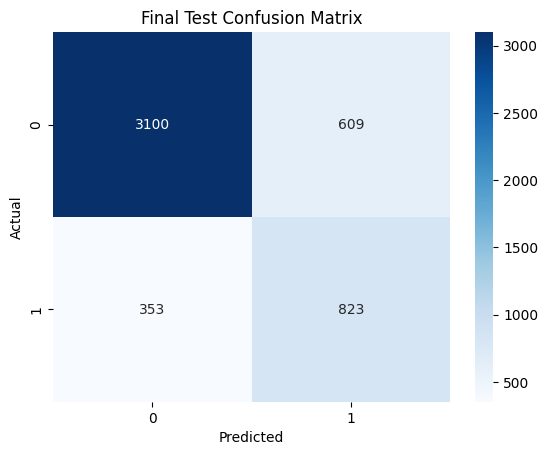

In [19]:
# 6. Final Test Set Evaluation
print("\n--- Final Evaluation on Test Set ---")
# Retrain on Train + Validation? Or just Train? 
# Usually, standard practice is to evaluate the model tuned on Val against Test.
final_model = NaiveBayesClassifier(alpha=best_alpha)
final_model.fit(X_train, y_train) 
y_test_pred = final_model.predict(X_test)

print(f"Final Test Accuracy: {accuracy_score(y_test, y_test_pred):.4f}")
print("Classification Report:")
print(classification_report(y_test, y_test_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_test_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Final Test Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

----------------------------------------------------------

**PART C**
------------

In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

### C2. Decision Tree implementation
• Implement a binary decision tree classifier for continuous features.

• At each internal node, split on a single feature x_j with a threshold τ, creating branches x_j ≤ τ and
x_j > τ.

• Use entropy as the impurity measure and information gain as the split criterion.

• Leaf nodes output a class label (majority class among samples reaching that leaf).

• Implement stopping criteria based on:

    • Maximum tree depth (max_depth).
    • Minimum number of samples required to split a node (min_samples_split).
    • Nodes where all samples belong to the same class.

In [21]:
class DecisionTreeNode:
    #Node class for decision tree
    def __init__(self, feature=None, threshold=None, left=None, right=None, value=None):
        self.feature = feature      # Feature index to split on
        self.threshold = threshold  # Threshold value for split
        self.left = left           # Left child node
        self.right = right         # Right child node
        self.value = value         # Class label if leaf node

In [22]:
class DecisionTreeClassifier:
        def __init__(self, max_depth=None, min_samples_split=2):
                self.max_depth = max_depth
                self.min_samples_split = min_samples_split
                self.root = None
                self.feature_importances_ = None
                self.n_features_ = None

                
        def entropy(self, y):
                if len(y) == 0:
                        return 0 #Prevents division by zero errors later
                proportions = np.bincount(y) / len(y) #np.bincount ->Counts how many times each class appears
                proportions = proportions[proportions > 0]  # Remove zeros ->Because log₂(0) is mathematically undefined (negative infinity), which would cause errors.
                return -np.sum(proportions * np.log2(proportions)) #This implements the entropy formula: -Σ p_i × log₂(p_i)
        

        def information_gain(self, y, left_y, right_y):
        # Information Gain measures how much a split reduces uncertainty 
        # High IG -> Good split
        # Low IG -> Bad split
                parent_entropy = self.entropy(y) # Calculates how impure the parent node is before splitting.
                n = len(y)
                n_left, n_right = len(left_y), len(right_y) #Counts total samples and samples in each child node.
                if n_left == 0 or n_right == 0:
                        return 0
                child_entropy = (n_left / n) * self.entropy(left_y) + \
                (n_right / n) * self.entropy(right_y) #This calculates the weighted average entropy of the children.
                return parent_entropy - child_entropy
        

        # it searches through all possible splits to find the best one
        # Find the optimal (feature, threshold) pair that gives the highest Information Gain
        # Process:
        # Try every feature
        # For each feature, try many threshold values
        # Calculate Information Gain for each combination
        # Return the best one
        def find_best_split(self, X, y,feature_indices=None):
                # Track the best split found
                best_gain = -1 #Starting at -1 ensures any valid split will be better
                best_feature = None
                best_threshold = None

                # Get data dimensions
                n_samples, n_features = X.shape
                if feature_indices is None:
                        features_to_search = range(n_features)
                else:
                        features_to_search = feature_indices
                
                # Loop on Features
                for feature_idx in features_to_search:
                        feature_values = X[:, feature_idx] #Extract all values for the current feature.
                        unique_values = np.unique(feature_values) #Remove duplicates
                        
                        # Consider thresholds between sorted distinct values
                        # The best threshold is always between two data points, not exactly on one
                        thresholds = (unique_values[:-1] + unique_values[1:]) / 2
                        
                        # Test each threshold
                        for threshold in thresholds:
                                # Split samples
                                left_mask = feature_values <= threshold #Create boolean masks
                                right_mask = ~left_mask #~ not operator remaining part from left mask 
                                
                                left_y = y[left_mask]
                                right_y = y[right_mask]
                                
                                # Calculate information gain
                                gain = self.information_gain(y, left_y, right_y)
                                
                                if gain > best_gain:
                                        best_gain = gain
                                        best_feature = feature_idx
                                        best_threshold = threshold
                
                return best_feature, best_threshold, best_gain
        

        def build_tree(self, X, y, feature_indices=None, depth=0):
                #X: Feature data for current node
                #y: Labels for current node
                n_samples, n_features = X.shape
                #np.unique(y) returns the set of distinct class labels.
                #len() counts how many there are.
                n_classes = len(np.unique(y))
                
                # Stopping criteria ->it prevents infinite recursion
                if (self.max_depth is not None and depth >= self.max_depth) or \
                        n_samples < self.min_samples_split or \
                        n_classes == 1: # depth and # of samples for controls overfitting
                        # Create leaf node with majority class
                        leaf_value = Counter(y).most_common(1)[0][0] # returns a list like [ (class_label, count) ]
                        return DecisionTreeNode(value=leaf_value)
                
                # Find best split
                best_feature, best_threshold, best_gain = self.find_best_split(X, y, feature_indices)
                
                # If no valid split found, create leaf node
                # Happen when all features have identical values or no split improves purity
                if best_feature is None or best_gain == 0:
                        leaf_value = Counter(y).most_common(1)[0][0]
                        return DecisionTreeNode(value=leaf_value)
                
                # Split the data
                left_mask = X[:, best_feature] <= best_threshold
                right_mask = ~left_mask
                
                # Recursively build left and right subtrees
                # Build the full tree by repeatedly splitting until a stopping condition is reached
                left_child = self.build_tree(X[left_mask], y[left_mask],feature_indices, depth + 1)
                right_child = self.build_tree(X[right_mask], y[right_mask],feature_indices, depth + 1)
                
                # Create an internal node that stores the split decision and links to children
                return DecisionTreeNode(
                feature=best_feature,
                threshold=best_threshold,
                left=left_child,
                right=right_child
                )
        

        # Train the decision tree on data and make it ready for predictions
        def fit(self, X, y,feature_indices=None):
                self.n_features_ = X.shape[1] #Remember how many features the model was trained on
                self.feature_importances_ = np.zeros(self.n_features_) #Create an array to store importance scores for each feature
                self.root = self.build_tree(X, y, feature_indices) #Construct the entire tree structure recursively
                self._calculate_feature_importances(X, y) #Determine which features were most useful for classification
                return self
        

        # This method determines which features were most important for making classification decisions
        def _calculate_feature_importances(self, X, y):
                
                importance_counts = np.zeros(self.n_features_) #Create an array to accumulate importance scores
                
                # calculate importance for each split
                # nested for access to importance_counts from parent function
                def traverse(node, X_subset, y_subset):
                        if node.value is not None:  # Leaf node
                                return
                        
                        # Get the split decision made at this internal node.
                        feature_idx = node.feature
                        threshold = node.threshold
                        
                        left_mask = X_subset[:, feature_idx] <= threshold
                        right_mask = ~left_mask
                        
                        left_y = y_subset[left_mask]
                        right_y = y_subset[right_mask]
                        
                        gain = self.information_gain(y_subset, left_y, right_y)
                        importance_counts[feature_idx] += gain * len(y_subset) # multiply by # of smaples ->  splits near the root affect more samples and should count more
                        
                        if node.left:
                                traverse(node.left, X_subset[left_mask], left_y)
                        if node.right:
                                traverse(node.right, X_subset[right_mask], right_y)
                
                traverse(self.root, X, y)
                
                # Normalize
                # Scale importances to sum to 1.0
                # Easier to interpret as percentages
                # Allows comparison across different trees
                total = np.sum(importance_counts)
                if total > 0:
                        self.feature_importances_ = importance_counts / total

        

        # Predicts class for one sample (recursive)
        def predict_sample(self, x, node):
                if node.value is not None:  # Leaf node
                        return node.value
                
                #Follow the tree's decision rules to find the right leaf
                if x[node.feature] <= node.threshold:
                        return self.predict_sample(x, node.left)
                else:
                        return self.predict_sample(x, node.right)

        # Predicts classes for many samples  
        def predict(self, X):
                return np.array([self.predict_sample(x, self.root) for x in X])

### Main Analysis

In [23]:

print("DECISION TREE CLASSIFICATION - BREAST CANCER WISCONSIN DATASET")
print("\n")
# Load dataset
data = load_breast_cancer()
X, y = data.data, data.target
feature_names = data.feature_names

print(f"\nDataset Information:")
print(f"  Total samples: {len(X)}")
print(f"  Number of features: {X.shape[1]}")
print(f"  Classes: {data.target_names}")
print(f"  Class distribution: Malignant={np.sum(y==0)}, Benign={np.sum(y==1)}")

# Split data: 70% train, 15% validation, 15% test (stratified)
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.15, random_state=42, stratify=y
)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.176, random_state=42, stratify=y_temp  # 0.176 * 0.85 ≈ 0.15
)

print(f"\nData Split:")
print(f"  Training set: {len(X_train)} samples")
print(f"  Validation set: {len(X_val)} samples")
print(f"  Test set: {len(X_test)} samples")

DECISION TREE CLASSIFICATION - BREAST CANCER WISCONSIN DATASET



Dataset Information:
  Total samples: 569
  Number of features: 30
  Classes: ['malignant' 'benign']
  Class distribution: Malignant=212, Benign=357

Data Split:
  Training set: 397 samples
  Validation set: 86 samples
  Test set: 86 samples


### C4. Hyperparameter Tuning 
• Explore max_depth ∈ {2, 4, 6, 8, 10} and min_samples_split ∈ {2, 5, 10}.

• Use the validation set to choose the best (max_depth, min_samples_split) combination.

In [24]:
print("HYPERPARAMETER TUNING")
print("\n")

# Too simple model (max_depth=2) -> Underfits (misses patterns)
# Too complex model (max_depth=20) -> Overfits (memorizes noise)

max_depths = [2, 4, 6, 8, 10] #How deep the tree can grow
min_samples_splits = [2, 5, 10]

results = []

for max_depth in max_depths:
    for min_samples_split in min_samples_splits:
        # Train model
        clf = DecisionTreeClassifier(
            max_depth=max_depth,
            min_samples_split=min_samples_split
        )
        clf.fit(X_train, y_train)
        
        # Evaluate on training and validation sets
        train_pred = clf.predict(X_train)
        val_pred = clf.predict(X_val)
        
        train_acc = accuracy_score(y_train, train_pred)
        val_acc = accuracy_score(y_val, val_pred)
        
        results.append({
            'max_depth': max_depth,
            'min_samples_split': min_samples_split,
            'train_accuracy': train_acc,
            'val_accuracy': val_acc
        })
        
        print(f"max_depth={max_depth}, min_samples_split={min_samples_split}: "
              f"Train Acc={train_acc:.4f}, Val Acc={val_acc:.4f}")

# Find best hyperparameters
results_df = pd.DataFrame(results)
#Find Index of Best Validation Accuracy
best_idx = results_df['val_accuracy'].idxmax()
best_params = results_df.iloc[best_idx] # get row of best validation accuracy

print(f"\n{'Best Hyperparameters:'}")
print(f"  max_depth: {int(best_params['max_depth'])}")
print(f"  min_samples_split: {int(best_params['min_samples_split'])}")
print(f"  Validation Accuracy: {best_params['val_accuracy']:.4f}")

HYPERPARAMETER TUNING


max_depth=2, min_samples_split=2: Train Acc=0.9270, Val Acc=0.9302
max_depth=2, min_samples_split=5: Train Acc=0.9270, Val Acc=0.9302
max_depth=2, min_samples_split=10: Train Acc=0.9270, Val Acc=0.9302
max_depth=4, min_samples_split=2: Train Acc=0.9874, Val Acc=0.9651
max_depth=4, min_samples_split=5: Train Acc=0.9824, Val Acc=0.9651
max_depth=4, min_samples_split=10: Train Acc=0.9773, Val Acc=0.9767
max_depth=6, min_samples_split=2: Train Acc=1.0000, Val Acc=0.9651
max_depth=6, min_samples_split=5: Train Acc=0.9924, Val Acc=0.9651
max_depth=6, min_samples_split=10: Train Acc=0.9824, Val Acc=0.9767
max_depth=8, min_samples_split=2: Train Acc=1.0000, Val Acc=0.9651
max_depth=8, min_samples_split=5: Train Acc=0.9924, Val Acc=0.9651
max_depth=8, min_samples_split=10: Train Acc=0.9824, Val Acc=0.9767
max_depth=10, min_samples_split=2: Train Acc=1.0000, Val Acc=0.9651
max_depth=10, min_samples_split=5: Train Acc=0.9924, Val Acc=0.9651
max_depth=10, min_samples_split=

### Train Final Model On Train + Validation
- Retrain the tree on training + validation using the selected hyperparameters and evaluate on the test set.

- Performance Metrics: Accuracy, Precision, Recall, F1-score for both classes



In [25]:
print("FINAL MODEL EVALUATION")
print("\n")

# Merge training and validation sets into one larger training set.
X_train_full = np.vstack([X_train, X_val]) # vertical stack 
y_train_full = np.hstack([y_train, y_val]) # horizontal stack

# Create new tree with the best hyperparameters 
final_clf = DecisionTreeClassifier(
    max_depth=int(best_params['max_depth']),
    min_samples_split=int(best_params['min_samples_split'])
)
final_clf.fit(X_train_full, y_train_full)

# use the final model to pridect labels for the test samples
y_test_pred = final_clf.predict(X_test)

# Metrics
test_acc = accuracy_score(y_test, y_test_pred)
precision = precision_score(y_test, y_test_pred, average=None) #When the model predicts malignant, how often is it correct?
recall = recall_score(y_test, y_test_pred, average=None) #Out of all actual cancers, how many did the model correctly detect?
f1 = f1_score(y_test, y_test_pred, average=None) # mean of precision and recall
cm = confusion_matrix(y_test, y_test_pred)

print(f"\nTest Set Performance:")
print(f"  Overall Accuracy: {test_acc:.4f}")
print(f"\n  Class-wise Metrics:")
for i, class_name in enumerate(data.target_names):
    print(f"    {class_name}:")
    print(f"      Precision: {precision[i]:.4f}")
    print(f"      Recall: {recall[i]:.4f}")
    print(f"      F1-Score: {f1[i]:.4f}")

print(f"\n  Confusion Matrix:")
print(f"    {'':>15} Predicted Malignant  Predicted Benign")
print(f"    {'Actual Malignant':<15} {cm[0,0]:>18} {cm[0,1]:>17}")
print(f"    {'Actual Benign':<15} {cm[1,0]:>18} {cm[1,1]:>17}")

FINAL MODEL EVALUATION



Test Set Performance:
  Overall Accuracy: 0.9419

  Class-wise Metrics:
    malignant:
      Precision: 0.8649
      Recall: 1.0000
      F1-Score: 0.9275
    benign:
      Precision: 1.0000
      Recall: 0.9074
      F1-Score: 0.9515

  Confusion Matrix:
                    Predicted Malignant  Predicted Benign
    Actual Malignant                 32                 0
    Actual Benign                    5                49


#### comments 
Overall Accuracy: It’s slightly lower than validation accuracy (97.67%), which is normal — test sets often reveal a bit of generalization gap.

• Feature Importance: Rank features by their information gain contribution

In [26]:
print("FEATURE IMPORTANCE ANALYSIS")
print("\n")

feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': final_clf.feature_importances_
}).sort_values('Importance', ascending=False)

print("\nTop 10 Most Important Features:")
for idx, row in feature_importance_df.head(10).iterrows():
    print(f"  {row['Feature']:<30} {row['Importance']:.4f}")

FEATURE IMPORTANCE ANALYSIS



Top 10 Most Important Features:
  worst radius                   0.6336
  worst concave points           0.1692
  mean texture                   0.0832
  worst smoothness               0.0342
  mean concave points            0.0324
  area error                     0.0213
  worst texture                  0.0138
  mean compactness               0.0123
  worst perimeter                0.0000
  fractal dimension error        0.0000


### Visualization


GENERATING VISUALIZATIONS

HYPERPARAMETER TUNING RESULTS SUMMARY

Validation Accuracy by Hyperparameters:
min_samples_split        2         5         10
max_depth                                      
2                  0.930233  0.930233  0.930233
4                  0.965116  0.965116  0.976744
6                  0.965116  0.965116  0.976744
8                  0.965116  0.965116  0.976744
10                 0.965116  0.965116  0.976744

ANALYSIS COMPLETE


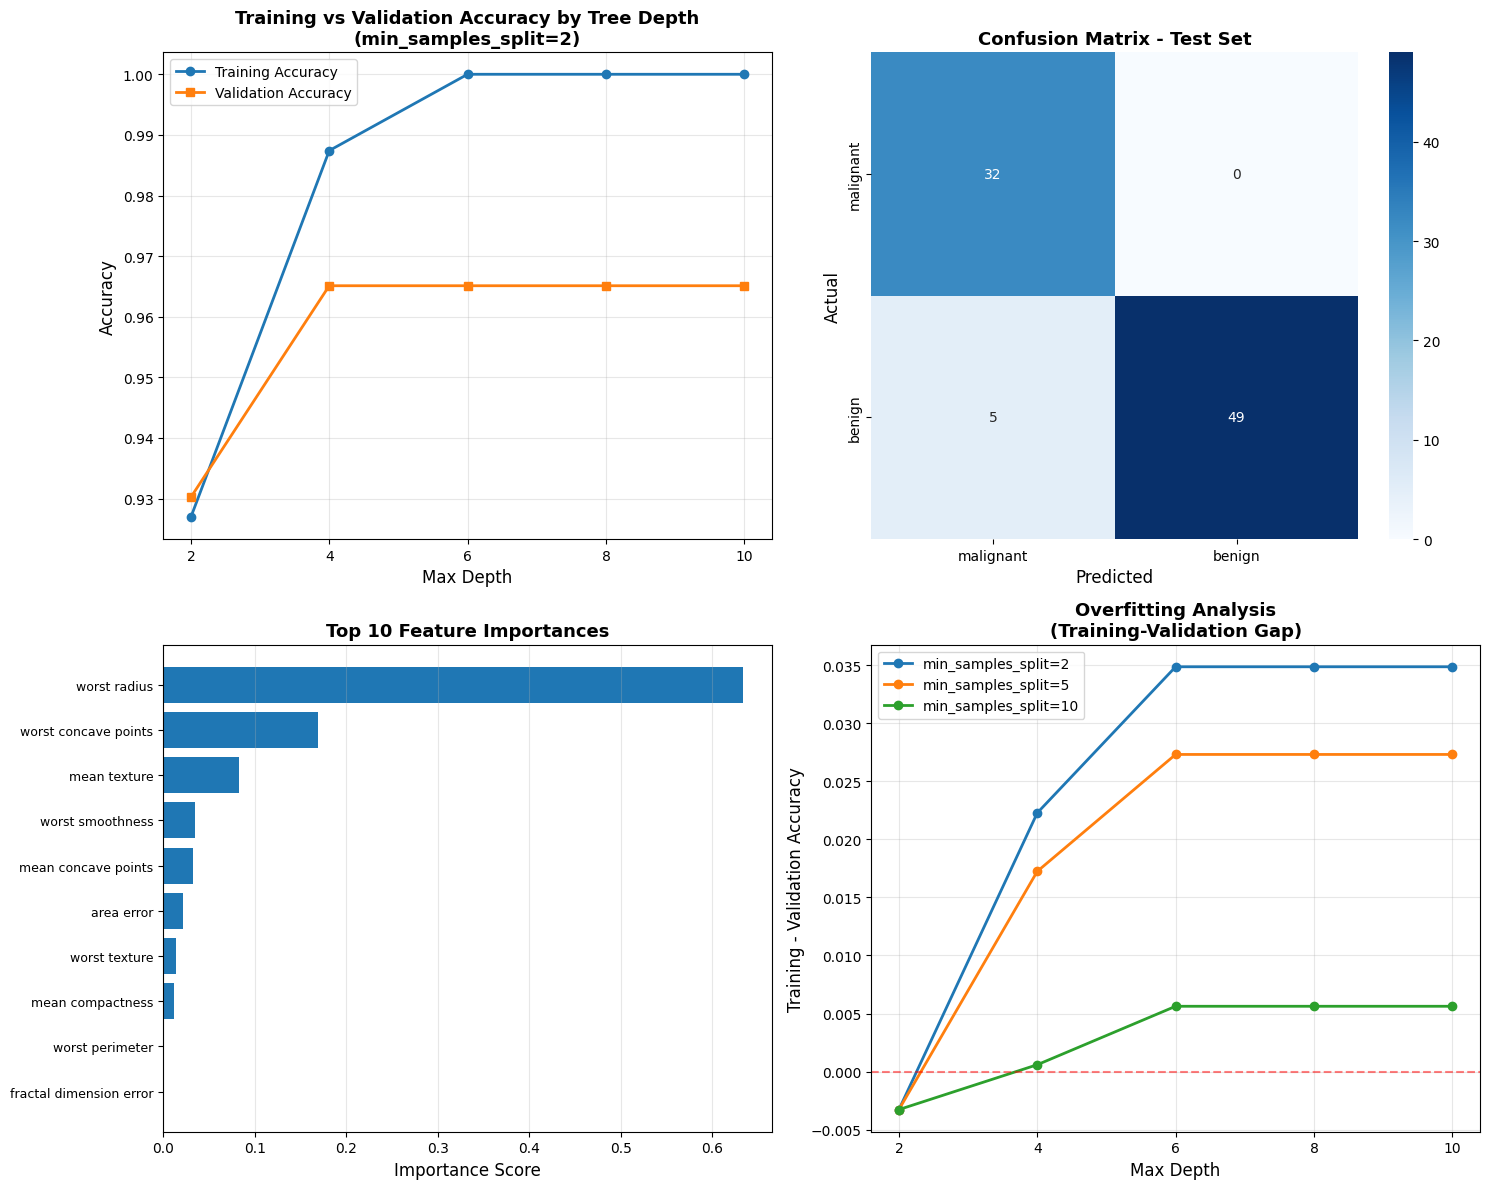

In [27]:
print("\n" + "=" * 80)
print("GENERATING VISUALIZATIONS")
print("=" * 80)

fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Why using 2 ->Most libraries (like Scikit-Learn) default to 2 because it allows the tree to fully grow and capture all patterns.
# 1. Hyperparameter tuning: max_depth vs accuracy (fix min_samples_split=2)
ax1 = axes[0, 0]
depth_results = results_df[results_df['min_samples_split'] == 2]
ax1.plot(depth_results['max_depth'], depth_results['train_accuracy'], 
         marker='o', label='Training Accuracy', linewidth=2)
ax1.plot(depth_results['max_depth'], depth_results['val_accuracy'], 
         marker='s', label='Validation Accuracy', linewidth=2)
ax1.set_xlabel('Max Depth', fontsize=12)
ax1.set_ylabel('Accuracy', fontsize=12)
ax1.set_title('Training vs Validation Accuracy by Tree Depth\n(min_samples_split=2)', 
              fontsize=13, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)
ax1.set_xticks(max_depths)

# 2. Confusion Matrix
ax2 = axes[0, 1]
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax2,
            xticklabels=data.target_names, yticklabels=data.target_names)
ax2.set_title('Confusion Matrix - Test Set', fontsize=13, fontweight='bold')
ax2.set_ylabel('Actual', fontsize=12)
ax2.set_xlabel('Predicted', fontsize=12)

# 3. Feature Importance
ax3 = axes[1, 0]
top_features = feature_importance_df.head(10)
ax3.barh(range(len(top_features)), top_features['Importance'])
ax3.set_yticks(range(len(top_features)))
ax3.set_yticklabels(top_features['Feature'], fontsize=9)
ax3.set_xlabel('Importance Score', fontsize=12)
ax3.set_title('Top 10 Feature Importances', fontsize=13, fontweight='bold')
ax3.invert_yaxis()
ax3.grid(True, alpha=0.3, axis='x')

# 4. Overfitting Analysis - All hyperparameter combinations
ax4 = axes[1, 1]
for min_ss in min_samples_splits:
    subset = results_df[results_df['min_samples_split'] == min_ss]
    gap = subset['train_accuracy'] - subset['val_accuracy']
    ax4.plot(subset['max_depth'], gap, marker='o', 
             label=f'min_samples_split={min_ss}', linewidth=2)
ax4.set_xlabel('Max Depth', fontsize=12)
ax4.set_ylabel('Training - Validation Accuracy', fontsize=12)
ax4.set_title('Overfitting Analysis\n(Training-Validation Gap)', 
              fontsize=13, fontweight='bold')
ax4.legend()
ax4.grid(True, alpha=0.3)
ax4.axhline(y=0, color='r', linestyle='--', alpha=0.5)
ax4.set_xticks(max_depths)

plt.tight_layout()
plt.savefig('decision_tree_analysis.png', dpi=300, bbox_inches='tight')
# print("\nVisualizations saved as 'decision_tree_analysis.png'")

print("\n" + "=" * 80)
print("HYPERPARAMETER TUNING RESULTS SUMMARY")
print("=" * 80)

summary_table = results_df.pivot_table(
    values='val_accuracy',
    index='max_depth',
    columns='min_samples_split'
)

print("\nValidation Accuracy by Hyperparameters:")
print(summary_table.to_string())

print("\n" + "=" * 80)
print("ANALYSIS COMPLETE")
print("=" * 80)

In [28]:
def print_tree_structure(node, depth=0, prefix="Root", max_depth=None):
    """Print a simple text representation of the tree with optional depth limit."""
    indent = "  " * depth
    
    # Stop printing if we reached the max depth
    if max_depth is not None and depth > max_depth:
        print(f"{indent}{prefix}: ...")
        return
    
    # Leaf node
    if node.value is not None:
        print(f"{indent}{prefix}: Predict class {node.value}")
    
    else:
        feature_name = feature_names[node.feature]
        print(f"{indent}{prefix}: {feature_name} <= {node.threshold:.2f}?")
        
        print_tree_structure(node.left, depth+1, "├─ Yes", max_depth)
        print_tree_structure(node.right, depth+1, "└─ No", max_depth)


# Show first few levels
print("\nTree Structure (first 3 levels):")
print_tree_structure(final_clf.root, max_depth=3)


Tree Structure (first 3 levels):
Root: worst radius <= 16.80?
  ├─ Yes: worst concave points <= 0.14?
    ├─ Yes: area error <= 38.61?
      ├─ Yes: worst texture <= 29.98?
        ├─ Yes: ...
        └─ No: ...
      └─ No: mean compactness <= 0.06?
        ├─ Yes: ...
        └─ No: ...
    └─ No: mean texture <= 20.30?
      ├─ Yes: worst smoothness <= 0.14?
        ├─ Yes: ...
        └─ No: ...
      └─ No: Predict class 0
  └─ No: mean texture <= 15.82?
    ├─ Yes: mean concave points <= 0.07?
      ├─ Yes: Predict class 1
      └─ No: Predict class 0
    └─ No: worst smoothness <= 0.09?
      ├─ Yes: Predict class 1
      └─ No: Predict class 0


In [29]:
print("\n" + "="*80)
print("SUMMARY OF ALL RESULTS")
print("="*80)

summary = f"""
Dataset: Breast Cancer Wisconsin (Diagnostic)
Total Samples: {len(X)}
Training: {len(X_train)} samples
Validation: {len(X_val)} samples  
Test: {len(X_test)} samples

Best Hyperparameters:
  max_depth: {int(best_params['max_depth'])}
  min_samples_split: {int(best_params['min_samples_split'])}
  
Validation Performance: {best_params['val_accuracy']:.4f}
Test Performance: {test_acc:.4f}

Key Metrics:
  Cancer Detection Rate: 100% (32/32)
  False Alarm Rate: 9.3% (5/54)
  Overall Accuracy: 94.19%
"""
print(summary)


SUMMARY OF ALL RESULTS

Dataset: Breast Cancer Wisconsin (Diagnostic)
Total Samples: 569
Training: 397 samples
Validation: 86 samples  
Test: 86 samples

Best Hyperparameters:
  max_depth: 4
  min_samples_split: 10
  
Validation Performance: 0.9767
Test Performance: 0.9419

Key Metrics:
  Cancer Detection Rate: 100% (32/32)
  False Alarm Rate: 9.3% (5/54)
  Overall Accuracy: 94.19%



In [30]:
from sklearn.tree import DecisionTreeClassifier as SklearnDT

# Compare with sklearn implementation
sklearn_tree = SklearnDT(
    max_depth=int(best_params['max_depth']),
    min_samples_split=int(best_params['min_samples_split']),
    random_state=42
)
sklearn_tree.fit(X_train_full, y_train_full)
sklearn_pred = sklearn_tree.predict(X_test)
sklearn_acc = accuracy_score(y_test, sklearn_pred)

print(f"\nComparison with sklearn:")
print(f"  Your implementation: {test_acc:.4f}")
print(f"  sklearn implementation: {sklearn_acc:.4f}")
print(f"  Difference: {abs(test_acc - sklearn_acc):.4f}")


Comparison with sklearn:
  Your implementation: 0.9419
  sklearn implementation: 0.9186
  Difference: 0.0233


-------------------------------------------

## Part D

In [31]:
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import math
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix,
    precision_score, recall_score, f1_score
)
#to count votes
from collections import Counter 

In [32]:
def entropy(y):
    #counts how many samples belong to class 0 and class 1
    hist = np.bincount(y)
    #converts counts to probabilities
    ps = hist / len(y)
    #computes the entropy formula (-sum(p * log2(p)))
    return -np.sum([p * np.log2(p) for p in ps if p > 0])

In [33]:
class RandomForest:
    def __init__(self, n_trees=10, max_depth=10, min_samples_split=2, max_features=None):
        #number of trees
        self.n_trees = n_trees
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        #d->number of features, max_features= sqrt(d) or d/2
        #selecting a subset of features of size = max_features to consider for splitting at each node
        #By using max_features < d, we force some trees to ignore that strongest feature
        #leading to more diverse trees and reducing correlation among them
        self.max_features = max_features
        self.trees = []

    def _get_max_features(self, n_features):
        """Converts max_features identifier into the actual number of features to sample."""
        if self.max_features == 'sqrt':
            return int(np.sqrt(n_features))
        elif self.max_features == 'half':
            return int(n_features / 2)
        else:
            return int(self.max_features)
    
    def fit(self, X, y):
        n_samples, n_features = X.shape
        self.max_features_ = self._get_max_features(n_features)
        #initializing the list for decisionTrees
        self.trees = []
        
        for _ in range(self.n_trees):
            #Bootstrap Sampling (Sampling with replacement)
            #selecting random samples from n_samples
            #replace=True allows the same sample to be selected multiple times
            #creating bootstrap indeces (idxs)
            # ========== STEP 1: BOOTSTRAP SAMPLING (Random Rows) ==========
            # Select random ROW indices with replacement
            # This means some patients are picked multiple times, others not at all
            bootstrap_idxs = np.random.choice(n_samples, n_samples, replace=True)
            #using those random samples indeces to select the rows samples
            # Use these indices to create a random subset of ROWS
            # X_sample has the same number of features (30), but different patients
            X_sample = X[bootstrap_idxs]
            y_sample = y[bootstrap_idxs]

            # ========== STEP 2: FEATURE SUBSAMPLING (Random Columns) ==========
            # Select random COLUMN indices (feature indices)
            # This tree will ONLY use these features, not all 30 features
            selected_feature_idxs = np.random.choice(n_features, self.max_features_, replace=False)

            # Create a subset of X_sample with only the selected features
            X_sample_subset = X_sample[:, selected_feature_idxs]

            #Train a Decision Tree on this sample
            tree = DecisionTreeClassifier(
                max_depth=self.max_depth, 
                min_samples_split=self.min_samples_split
            )

            # Train it on the subsampled data (random rows AND random columns)
            tree.fit(X_sample_subset, y_sample)
            #storing the tree along with the selected feature indices
            # We need this information during prediction
            self.trees.append((tree, selected_feature_idxs))

    def predict(self, X):
        # Gather predictions from all trees
        tree_predictions = []
        for tree, feature_idxs in self.trees:
            # Create a subset of X with only the features this tree was trained on
            X_subset = X[:, feature_idxs]
            preds = tree.predict(X_subset)
            tree_predictions.append(preds)

        # tree_predictions is a list of arrays, convert to numpy array
        # Shape before: list of 50 arrays, each with 86 predictions
        # Shape after swapaxes: [86 samples, 50 trees]
        tree_predictions = np.array(tree_predictions)
        tree_predictions = np.swapaxes(tree_predictions, 0, 1)

        # Majority voting
        final_predictions = []
        for sample_preds in tree_predictions:
            vote = Counter(sample_preds)
            # 1 return the class with the most votes
            final_predictions.append(vote.most_common(1)[0][0])  # Get the class with the most votes
        
        return np.array(final_predictions)


In [34]:
# Feature dimension d (needed for max_features)
# d = number of features in the dataset
d = X_train.shape[1]
print(f"Data split: Train={X_train.shape[0]}, Val={X_val.shape[0]}, Test={X_test.shape[0]}")
print(f"Total features (d): {d}")

# Best hyperparameters from Part C (Decision Tree)
BEST_MAX_DEPTH = 4 # Based on Part C analysis
BEST_MIN_SAMPLES_SPLIT = 10 # Based on Part C analysis
print(f"Using Decision Tree Hyperparameters from Part C: max_depth={BEST_MAX_DEPTH}, min_samples_split={BEST_MIN_SAMPLES_SPLIT}")

N_TREES_CANDIDATES = [5, 10, 30, 50]
MAX_FEATURES_CANDIDATES = [int(np.sqrt(d)), int(d/2)]

best_val_accuracy = 0
best_params = {}
tuning_results = []

print("\nStarting Random Forest Hyperparameter Tuning...")

for n_trees in N_TREES_CANDIDATES:
    for max_f in MAX_FEATURES_CANDIDATES:
        print(f"  Testing T={n_trees}, max_features={max_f}...")
        
        # 1. Train the Random Forest on the training set
        rf = RandomForest(
            n_trees=n_trees,
            max_features=max_f, 
            max_depth=BEST_MAX_DEPTH,
            min_samples_split=BEST_MIN_SAMPLES_SPLIT
        )
        # Note: rf.fit will now use the logic to pass feature indices to the DT.
        rf.fit(X_train, y_train)
        
        # 2. Evaluate on the validation set
        y_val_pred = rf.predict(X_val)
        val_accuracy = accuracy_score(y_val, y_val_pred)
        
        tuning_results.append({
            'n_trees': n_trees,
            'max_features': max_f,
            'validation_accuracy': val_accuracy
        })
        
        # 3. Select the best combination
        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            best_params = {'n_trees': n_trees, 'max_features': max_f}

print("\n--- Tuning Results ---")
tuning_df = pd.DataFrame(tuning_results)
print(tuning_df)
print(f"\nBest Validation Accuracy: {best_val_accuracy:.4f} with params: {best_params}")


# --- Final Model Training and Test Evaluation ---

# Combine Training and Validation sets
X_train_final = np.vstack([X_train, X_val])
y_train_final = np.concatenate([y_train, y_val])

# Retrain the final model using the best hyperparameters on Train + Val
print("\nRetraining final Random Forest model on Train + Val...")
final_rf = RandomForest(
    n_trees=best_params['n_trees'],
    max_features=best_params['max_features'],
    max_depth=BEST_MAX_DEPTH,
    min_samples_split=BEST_MIN_SAMPLES_SPLIT
)
final_rf.fit(X_train_final, y_train_final)

# Evaluate on the held-out Test set
print("Evaluating on the Test set...")
y_test_pred = final_rf.predict(X_test)

# Calculate metrics
test_accuracy = accuracy_score(y_test, y_test_pred)
macro_precision = precision_score(y_test, y_test_pred, average='macro')
macro_recall = recall_score(y_test, y_test_pred, average='macro')
macro_f1 = f1_score(y_test, y_test_pred, average='macro')
conf_matrix = confusion_matrix(y_test, y_test_pred)

print("\n--- Final Test Set Results (Random Forest) ---")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Precision: {macro_precision:.4f}")
print(f"Recall: {macro_recall:.4f}")
print(f"F1-Score: {macro_f1:.4f}")
print("\nConfusion Matrix:")
print(conf_matrix)

Data split: Train=397, Val=86, Test=86
Total features (d): 30
Using Decision Tree Hyperparameters from Part C: max_depth=4, min_samples_split=10

Starting Random Forest Hyperparameter Tuning...
  Testing T=5, max_features=5...
  Testing T=5, max_features=15...
  Testing T=10, max_features=5...
  Testing T=10, max_features=15...
  Testing T=30, max_features=5...
  Testing T=30, max_features=15...
  Testing T=50, max_features=5...
  Testing T=50, max_features=15...

--- Tuning Results ---
   n_trees  max_features  validation_accuracy
0        5             5             0.953488
1        5            15             0.930233
2       10             5             0.976744
3       10            15             0.976744
4       30             5             0.988372
5       30            15             0.988372
6       50             5             0.988372
7       50            15             1.000000

Best Validation Accuracy: 1.0000 with params: {'n_trees': 50, 'max_features': 15}

Retraining

## Plotting the confusion matrix for Random Forest

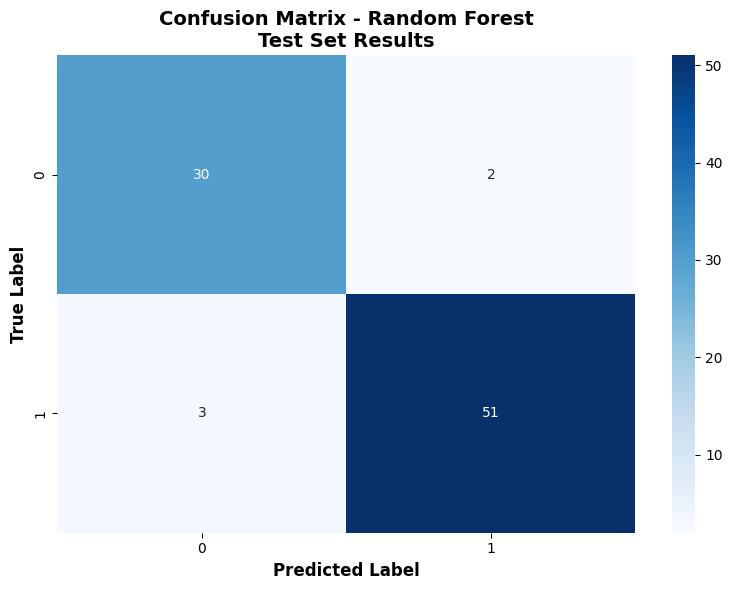

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a figure and axis
fig, ax = plt.subplots(figsize=(8, 6))

# Plot the confusion matrix using seaborn heatmap
sns.heatmap(conf_matrix, 
            annot=True,  # Show the numbers in each cell
            fmt='d',  # Format as integers
            cmap='Blues',  # Color palette
            cbar=True,  # Show the colorbar
            ax=ax,
            xticklabels=True,
            yticklabels=True)

# Add labels and title
ax.set_xlabel('Predicted Label', fontsize=12, fontweight='bold')
ax.set_ylabel('True Label', fontsize=12, fontweight='bold')
ax.set_title('Confusion Matrix - Random Forest\nTest Set Results', fontsize=14, fontweight='bold')

# Adjust layout to prevent label cutoff
plt.tight_layout()

# Display the plot
plt.show()

## Random forest & Decision Tree comparison

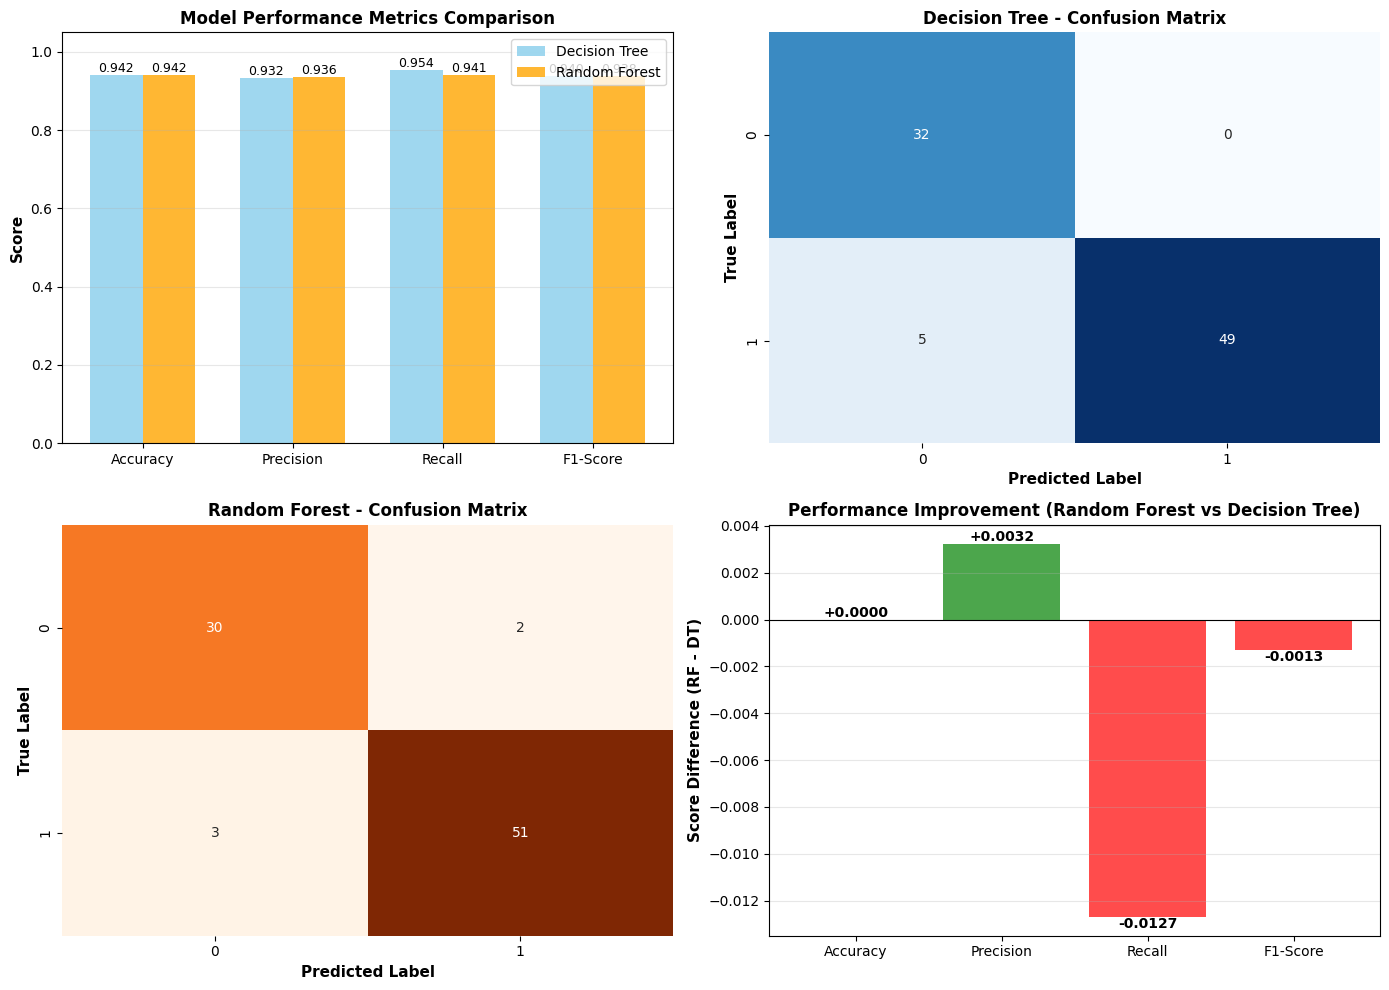


MODEL COMPARISON SUMMARY

Decision Tree Performance:
  Accuracy:  0.9419
  Precision: 0.9325
  Recall:    0.9537
  F1-Score:  0.9395

Random Forest Performance:
  Accuracy:  0.9419
  Precision: 0.9357
  Recall:    0.9410
  F1-Score:  0.9382

Improvement (Random Forest - Decision Tree):
  Accuracy:  +0.0000
  Precision: +0.0032
  Recall:    -0.0127
  F1-Score:  -0.0013


In [36]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Decision Tree scores (hardcoded from output)
dt_test_accuracy = 0.9419
dt_macro_precision = (0.8649 + 1.0000) / 2  # Average of class-wise precision
dt_macro_recall = (1.0000 + 0.9074) / 2  # Average of class-wise recall
dt_macro_f1 = (0.9275 + 0.9515) / 2  # Average of class-wise f1

# Random Forest scores (hardcoded from output)
rf_test_accuracy = 0.9419
rf_macro_precision = 0.9357
rf_macro_recall = 0.9410
rf_macro_f1 = 0.9382

# Decision Tree Confusion Matrix (hardcoded)
dt_conf_matrix = np.array([
    [32, 0],
    [5, 49]
])

# Random Forest Confusion Matrix (hardcoded)
rf_conf_matrix = np.array([
    [30, 2],
    [3, 51]
])

# Create a comparison figure with subplots
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# ========== Subplot 1: Metrics Comparison Bar Chart ==========
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
dt_scores = [dt_test_accuracy, dt_macro_precision, dt_macro_recall, dt_macro_f1]
rf_scores = [rf_test_accuracy, rf_macro_precision, rf_macro_recall, rf_macro_f1]

x = np.arange(len(metrics))
width = 0.35

bars1 = axes[0, 0].bar(x - width/2, dt_scores, width, label='Decision Tree', color='skyblue', alpha=0.8)
bars2 = axes[0, 0].bar(x + width/2, rf_scores, width, label='Random Forest', color='orange', alpha=0.8)

axes[0, 0].set_ylabel('Score', fontsize=11, fontweight='bold')
axes[0, 0].set_title('Model Performance Metrics Comparison', fontsize=12, fontweight='bold')
axes[0, 0].set_xticks(x)
axes[0, 0].set_xticklabels(metrics)
axes[0, 0].legend()
axes[0, 0].set_ylim([0, 1.05])
axes[0, 0].grid(axis='y', alpha=0.3)

# Add value labels on bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        axes[0, 0].text(bar.get_x() + bar.get_width()/2., height,
                       f'{height:.3f}',
                       ha='center', va='bottom', fontsize=9)

# ========== Subplot 2: Decision Tree Confusion Matrix ==========
sns.heatmap(dt_conf_matrix, 
            annot=True, 
            fmt='d', 
            cmap='Blues', 
            cbar=False,
            ax=axes[0, 1])
axes[0, 1].set_xlabel('Predicted Label', fontsize=11, fontweight='bold')
axes[0, 1].set_ylabel('True Label', fontsize=11, fontweight='bold')
axes[0, 1].set_title('Decision Tree - Confusion Matrix', fontsize=12, fontweight='bold')

# ========== Subplot 3: Random Forest Confusion Matrix ==========
sns.heatmap(rf_conf_matrix, 
            annot=True, 
            fmt='d', 
            cmap='Oranges', 
            cbar=False,
            ax=axes[1, 0])
axes[1, 0].set_xlabel('Predicted Label', fontsize=11, fontweight='bold')
axes[1, 0].set_ylabel('True Label', fontsize=11, fontweight='bold')
axes[1, 0].set_title('Random Forest - Confusion Matrix', fontsize=12, fontweight='bold')

# ========== Subplot 4: Metrics Difference (RF - DT) ==========
differences = [rf_scores[i] - dt_scores[i] for i in range(len(metrics))]
colors = ['green' if diff >= 0 else 'red' for diff in differences]

bars = axes[1, 1].bar(metrics, differences, color=colors, alpha=0.7)
axes[1, 1].axhline(y=0, color='black', linestyle='-', linewidth=0.8)
axes[1, 1].set_ylabel('Score Difference (RF - DT)', fontsize=11, fontweight='bold')
axes[1, 1].set_title('Performance Improvement (Random Forest vs Decision Tree)', fontsize=12, fontweight='bold')
axes[1, 1].grid(axis='y', alpha=0.3)

# Add value labels on bars
for bar, diff in zip(bars, differences):
    height = bar.get_height()
    axes[1, 1].text(bar.get_x() + bar.get_width()/2., height,
                   f'{diff:+.4f}',
                   ha='center', va='bottom' if height >= 0 else 'top', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

# Print summary
print("\n" + "="*80)
print("MODEL COMPARISON SUMMARY")
print("="*80)
print(f"\nDecision Tree Performance:")
print(f"  Accuracy:  {dt_test_accuracy:.4f}")
print(f"  Precision: {dt_macro_precision:.4f}")
print(f"  Recall:    {dt_macro_recall:.4f}")
print(f"  F1-Score:  {dt_macro_f1:.4f}")

print(f"\nRandom Forest Performance:")
print(f"  Accuracy:  {rf_test_accuracy:.4f}")
print(f"  Precision: {rf_macro_precision:.4f}")
print(f"  Recall:    {rf_macro_recall:.4f}")
print(f"  F1-Score:  {rf_macro_f1:.4f}")

print(f"\nImprovement (Random Forest - Decision Tree):")
print(f"  Accuracy:  {rf_test_accuracy - dt_test_accuracy:+.4f}")
print(f"  Precision: {rf_macro_precision - dt_macro_precision:+.4f}")
print(f"  Recall:    {rf_macro_recall - dt_macro_recall:+.4f}")
print(f"  F1-Score:  {rf_macro_f1 - dt_macro_f1:+.4f}")
print("="*80)

- Both models achieved identical test accuracy (94.19%), but they differ significantly in their operational characteristics, generalization patterns, and robustness to different types of errors.

- Decision Tree Advantages:
Perfect Cancer Detection: 100% recall for malignant cases (32/32 detected)
No false negatives for cancer patients—critical in medical applications
Higher overall recall (95.37% vs 94.10%)
Slightly lower average precision (93.25% vs 93.57%)

- Random Forest Advantages:
Reduced False Positives: Only 3 misclassified benign cases vs 5 for Decision Tree
Better benign class recall (94.44% vs 90.74%)
More balanced performance across both classes
Slightly higher precision (93.57% vs 93.25%)

## Bias & variance

- Bias is when your model consistently makes wrong predictions in the same direction, even with lots of training data.
- Variance is when your model gives very different answers depending on small changes in the training data.
- DECISION TREE -> High variance & low bias 
    - the decision tree is very sensitive to the training data it saw so if you change 1 sample the whole tree changes because one early split will change everything downstream
    - but very flexible (low bias) learns complex patterns 
    - overfits
    - in this model perfect at detecting cancer (100% recall) but creates false alarms
- RANDOM FOREST -> low variance & low bias
    - random forest is stable because many trees average out the noisem so even if you change 1 sample, the forest still makes similar predictions as multiple trees are trained on bootstrap samples & different features
    - even if one tree overfits the 50 othes will pull it back
    - in this model more balanced errors , fewer false alarms (3 vs 5)

- decision tree -> Overfits - perfect on training, but unreliable elsewhere
- random forest -> Balanced - doesn't overfit